# Milestone 4 - CS109B Project Group 29
**"Predicting Movie Genres"**<br>
**CS109B (Spring 2017) Final Project Group 29**<br>
Calvin J Chiew, Tim Hagmann, Ji Hua<br>
TF: Kela Roberts<br>

## Deliverables

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc.
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc.
- Discussion of the results, how much improvement you gained with fine tuning, etc.
- Discussion of at least one additional exploratory idea you pursued

## Setup

### Clear namespace
Removes all previously loaded objects. 

In [1]:
# Clear namespace
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

### Import Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
import numpy as np
from time import time, sleep

# Ploting and image operations
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from PIL import Image
from PIL import ImageEnhance
import PIL.ImageOps

# Sklearn
from sklearn import preprocessing, metrics

# Keras libraries
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Conv3D, MaxPooling3D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K

# Other
import tensorflow as tf
import os
import sys
import random
import warnings
from six.moves import cPickle as pickle
from __future__ import print_function

Using TensorFlow backend.


### Set a random seed (for reproducibility)

In [3]:
np.random.seed(123) # Set random seed

---

## Overview

In this milestone, we will use movie posters extracted from TMDb to develop deep learning networks for the task of multi-label movie genre prediction. We will train one small convolutional neural network (CNN) from scratch using Keras with TensorFlow backend, as well as fine-tune another existing pre-trained network, and compare their results. To speed up computation, the models were run on the "p2.xlarge" GPU compute instances on Amazon Web Services (AWS)'s Elastic Compute Cloud (EC2). To reproduce the EC2 setup, please see setup instructions here: https://github.com/greenore/deep-learning-project/tree/master/setup.

---

## Data Preparation

Previously, we have downloaded posters for about 69,000 movies from TMDb in w154 resolution (154x231 pixels) and `.jpg` format. Here, we use the Python Imaging Library (PIL) to pre-process these `.jpg` images into matrices of pixel values. All posters are resized to 154x154 pixels and then their RGB channel values are extracted into matrices of dimensions 154x154x3.

We also stored the corresponding genre labels (there are a total of 19 different genres) in a separate pickle file. To limit output file sizes, we processed the posters in batches of 1000 posters (total 69 batches).

In [4]:
genres = pd.read_csv('/home/ubuntu/data/clean_data/genres_70k_new.txt')
genres = genres.drop('TVMovie', 1)

In [5]:
tmdb_index_dict={}
for i in range(genres.shape[0]):
    tmdb_index_dict[genres.iloc[i,0]]=i

In [7]:
DATA_PATH = "/home/ubuntu/new_data/data/poster_154/"
SAVE_PATH="/home/ubuntu/new_data/data/poster_154_resize/"
VALIDATION_PERCENT = .2
TEST_PERCENT = .2
IMAGE_WIDTH = 154
IMAGE_HEIGHT=154
IMAGE_SIZE=154
NUM_CHANNELS = 3 # RGB channels
PIXEL_DEPTH = 255.0
NUM_GENRES = 19
NUM_ROWS=1000
PARTITION_TEST = False

In [8]:
def to_rgb(im):
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, :] = im[:, :, np.newaxis]
    return ret
def read_image_from_file(file_path):
    img = Image.open(file_path).convert('RGB')
    img = img.resize((IMAGE_WIDTH,IMAGE_HEIGHT), Image.ANTIALIAS) #downsample image
    pixel_values = np.array(img.getdata())
    return np.reshape(pixel_values, [IMAGE_WIDTH,IMAGE_HEIGHT, NUM_CHANNELS])
def make_dataset_arrays(num_rows=NUM_ROWS):
    data = np.ndarray((num_rows, IMAGE_WIDTH,IMAGE_HEIGHT, NUM_CHANNELS), dtype=np.float32)
    labels = np.ndarray((num_rows, NUM_GENRES), dtype=np.int32)
    return data, labels
def scale_pixel_values(dataset):
    return (dataset - PIXEL_DEPTH / 2.0) / PIXEL_DEPTH


In [9]:
train_data, train_labels = make_dataset_arrays()
num_train = 0
num_group = 0
startTime = time()
for filename in os.listdir(DATA_PATH):
    if filename.endswith(".jpg"): 
        
        if num_train<NUM_ROWS:
            image=read_image_from_file(DATA_PATH+filename)
            tmdb_id=int(filename.split(".")[0])
            index=tmdb_index_dict[tmdb_id]
            labels=genres.iloc[index,1:]
            train_data[num_train]=image
            train_labels[num_train]=labels
            num_train+=1
        else:
            pickle_file = SAVE_PATH+str(num_group)+'_data.pickle'
            save = {
                'train_data': train_data,
                'train_labels': train_labels,
            }
            pickle.dump(save,open(pickle_file, 'wb'))
            train_data = scale_pixel_values(train_data)
            train_data, train_labels = make_dataset_arrays()
            num_train = 0
            num_group+=1
            endTime = time()-startTime
            startTime = time()
            print(num_group,endTime)
    else:
        continue


1 23.07148838043213
2 23.129584550857544
3 23.35673761367798
4 23.262993574142456
5 23.149495124816895
6 23.00201940536499
7 22.927311897277832
8 22.939159154891968
9 23.064728498458862
10 22.971879959106445
11 23.085129499435425
12 24.443018674850464
13 24.3766028881073
14 24.22775650024414
15 24.348602533340454
16 24.058658599853516
17 24.22340726852417
18 24.41267442703247
19 24.15579056739807
20 24.253930807113647
21 25.006831407546997
22 24.567741632461548
23 24.416815280914307
24 24.119917392730713
25 24.19269037246704
26 24.41075086593628
27 24.368112564086914
28 24.50965452194214
29 25.553877592086792
30 24.256695985794067
31 24.258487701416016
32 24.21980881690979
33 24.34823703765869
34 24.676378965377808
35 24.258639335632324
36 24.213446617126465
37 23.88783574104309
38 24.61973214149475
39 25.433425426483154
40 25.156229496002197
41 24.31625986099243
42 24.32528328895569
43 25.392767429351807
44 24.759549140930176
45 24.387789726257324
46 24.285592794418335
47 24.701051712

---

## Training a Network from Scratch

In view of computation time and to focus on the correctness of our code (for now), we only used 10,000 posters (10 batches) for training, validation and testing each, even though we had data for 69,000 posters (69 batches). As the posters were grouped into batches in no particular pattern, this represents a random sampling for each set. We intend to increase the number of training and testing samples for our final project milestone.

### Network Architecture & Parameter Settings

The architecure of our CNN is as follows:
- [154x154x3] INPUT: 154x154 RGB image
- [150x150x32] CONV1: 32 5x5 filters at stride 1, pad 0
- [148x148x32] CONV2: 32 3x3 filters at stride 1, pad 0
- [74x74x32] MAXPOOL1: 2x2 filters at stride 2
- [72x72x32] CONV3: 32 3x3 filters at stride 1, pad 0
- [70x70x32] CONV4: 32 3x3 filters at stride 1, pad 0
- [35x35x32] MAXPOOL2: 2x2 filters at stride 2
- FC1: 64 neurons
- FC2: 19 neurons (output classes)

Other design choices made are as follows:
- Activation function: Rectified linear unit (ReLU) for hidden layers, sigmoid for output layer
- Optimization method: Adam
- Loss function: Binary cross-entropy
- Dropout: 0.25 on hidden layer, 0.5 on fully-connected layer
- Regularization: None (for now, KIV to add L2)
- Weight initialization: Glorot uniform
- Data pre-processing: Centering and normalization
- Data augmentation: Re-scaling, rotation, width shift, height shift, horizontal flip

The main parameters of our network are as follows:
- Learning rate: 0.1, reduced by factor of 0.2 when validation loss plateaus for 1 epoch, until minimum of 0.001
- Batch size: 500
- Number of epochs: 10 (fixed for now, KIV to add early stopping when validation loss plateaus for X number of epochs)

In [9]:
DATA_PATH = "/home/ubuntu/new_data/data/poster_154/"
SAVE_PATH="/data/poster_154_resize/"
VALIDATION_PERCENT = .2
TEST_PERCENT = .2
IMAGE_WIDTH = 154
IMAGE_HEIGHT = 154
IMAGE_SIZE = 154
NUM_CHANNELS = 3 # RGB channels
PIXEL_DEPTH = 255.0
NUM_GENRES = 19
NUM_ROWS=1000
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 500
# this is fixed, we have 19 output classes
num_classes = NUM_GENRES
classes = NUM_GENRES
# sample batch
num_batch = 15

In [10]:
input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT, 3)
#sample_index=random.sample(range(69), num_batch)
sample_index=np.arange(30)
train_index=sample_index[:10]
test_index=sample_index[10:20]
val_index=sample_index[20:]
num_test=len(test_index)*NUM_ROWS
num_train=len(train_index)*NUM_ROWS
num_val=len(val_index)*NUM_ROWS
train_X=np.zeros((num_train,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
train_Y=np.zeros((num_train,NUM_GENRES))
test_X=np.zeros((num_test,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
test_Y=np.zeros((num_test,NUM_GENRES))
val_X=np.zeros((num_val,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
val_Y=np.zeros((num_val,NUM_GENRES))

In [11]:
# Training data
for i in range(len(train_index)):
    file_name=str(train_index[i])+"_data.pickle"
    pickle_file=SAVE_PATH+file_name
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        train_X[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_data']
        train_Y[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_labels']

In [12]:
# Test data
for i in range(len(test_index)):
    file_name=str(test_index[i])+"_data.pickle"
    pickle_file=SAVE_PATH+file_name
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        test_X[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_data']
        test_Y[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_labels']

In [13]:
# Validation data
for i in range(len(val_index)):
    file_name=str(val_index[i])+"_data.pickle"
    pickle_file=SAVE_PATH+file_name
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        val_X[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_data']
        val_Y[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_labels']

In [14]:
print(train_X.shape)
print(test_X.shape)
print(val_X.shape)

(10000, 154, 154, 3)
(10000, 154, 154, 3)
(10000, 154, 154, 3)


In [15]:
datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

#### Building the Network

In [16]:
model = Sequential()
# input: 154x154 images with 3 channels -> (154, 154, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_GENRES,activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 70, 70, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0         
__________

In [17]:
adam=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = SGD(lr=0.1, momentum=0.9)
#early_stopping = EarlyStopping(monitor='val_loss',patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=1, min_lr=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [18]:
# number of iterations over the complete training data
epochs = 10
history = model.fit_generator(datagen.flow(train_X, train_Y, batch_size=batch_size), 
                    steps_per_epoch=len(train_X) / batch_size,
                    epochs=epochs,
                    validation_data=datagen.flow(test_X, test_Y),
                    validation_steps=len(test_X) / batch_size,
                    callbacks=[reduce_lr])

Epoch 1/10
20/20 [==============================] - 52s - loss: 1.6388 - acc: 0.8750 - val_loss: 1.7165 - val_acc: 0.8935

### Evaluating Network Performance

#### Baseline Model (Benchmark)

Previously, we created a baseline model to serve as a benchmark. This model flags a genre '1' randomly at a probability of around 10%, which is the overall proportion of flag '1' across all 19 genre classes.

In [19]:
def random_classifier(df_y):
    prop = df_y.sum() / df_y.shape[0]
    pred = np.random.binomial(1, np.mean(prop), df_y.shape)
    return pred

In [20]:
# naive model
np.random.seed(123)
pred_baseline = random_classifier(pd.DataFrame(val_Y))

# Drop tmdb_id
genres = genres.drop('tmdb_id', 1)

# show test accuracies for each class
acc_baseline = np.mean(pd.DataFrame(pred_baseline, columns=genres.columns) == pd.DataFrame(val_Y, columns=genres.columns))
acc_baseline

Adventure          0.8375
Fantasy            0.8581
Animation          0.8521
Drama              0.5611
Horror             0.8083
Action             0.7734
Comedy             0.6560
History            0.8806
Western            0.8723
Thriller           0.7863
Crime              0.8322
Documentary        0.8208
Science Fiction    0.8505
Mystery            0.8556
Music              0.8610
Romance            0.7854
Family             0.8435
War                0.8757
Foreign            0.8372
dtype: float64

In [21]:
# overall accuracy
print("Overall baseline accuracy", round(acc_baseline.sum() / 19 * 100, 2), "%\n")

Overall baseline accuracy 81.3 %



In [22]:
# F1 score
print("Precision baseline", round(metrics.precision_score(val_Y, pred_baseline, average='weighted'), 3))
print("Recall baseline", round(metrics.recall_score(val_Y, pred_baseline, average='weighted'), 3))
print("F1 score baseline", round(metrics.f1_score(val_Y, pred_baseline, average='weighted'), 3))

Precision baseline 0.202
Recall baseline 0.108
F1 score baseline 0.123


#### CNN Trained from Scratch

In [23]:
# Predict on the test set
pred_val_Y = model.predict(val_X)

In [24]:
# show test accuracies for each class
acc_baseline = np.mean(pd.DataFrame(pred_val_Y, columns=genres.columns) == pd.DataFrame(val_Y, columns=genres.columns))
acc_baseline

Adventure          0.9257
Fantasy            0.9546
Animation          0.9436
Drama              0.5749
Horror             0.8941
Action             0.8480
Comedy             0.6964
History            0.9754
Western            0.9720
Thriller           0.8580
Crime              0.9155
Documentary        0.9095
Science Fiction    0.9406
Mystery            0.9517
Music              0.9561
Romance            0.8573
Family             0.9318
War                0.9759
Foreign            0.9276
dtype: float64

In [36]:
# overall accuracy
print("Overall accuracy CNN(from scratch)", round(acc_baseline.sum() / 19 * 100, 2), "%\n")

Overall baseline accuracy 89.52 %



In [48]:
warnings.filterwarnings('ignore')
# F1 score
print("Precision CNN(from scratch)", round(metrics.precision_score(val_Y, pred_val_Y, average='weighted'), 3))
print("Recall CNN(from scratch)", round(metrics.recall_score(val_Y, pred_val_Y, average='weighted'), 3))
print("F1 score CNN(from scratch)", round(metrics.f1_score(val_Y, pred_val_Y, average='weighted'), 3))

Precision baseline 0.0
Recall baseline 0.0
F1 score baseline 0.0


Our network trained from scratch achieved a test accuracy of 89.52%, which is higher than baseline. However, from the precision-recall scores, it appears the model always predicts '0' for the genre flag. This might be due to class imbalance in the dataset, or insufficient optimization of our model architecture and settings. We hope to improve on this with more time.

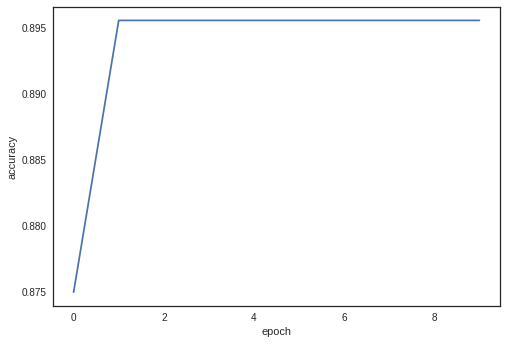

In [49]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")

In the plot above, we visualize the validation accuracy over the training process. The accuracy appears to have plateaued after the 1st epoch.

### Features Learnt

Here, we visualize some of the filters, which are essentially the weights from the hidden units.

In [50]:
# Look at the weights of a layer
layer = model.layers[1]
weights = layer.get_weights()
print("Shape of W")
print(weights[0].shape)

Shape of W
(3, 3, 32, 32)


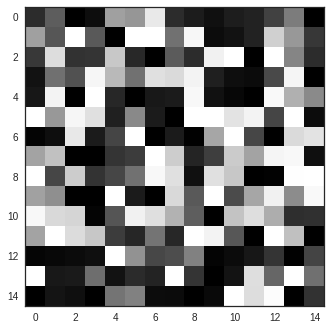

In [51]:
# First filters
filterTiles = np.array([])
index = 0
for i in range(5):
    filterRow = []
    for j in range(5):
        w = weights[0][:,:, 0, index]
        w = w.reshape(3, 3)
        w = w-np.min(w)
        w = w / np.max(w)
        filterRow.extend(w)
        index+=1
    filterRow = np.array(filterRow)
    if not filterTiles.shape[0] == 0:
        filterTiles = np.hstack([filterTiles, filterRow])
    else:
        filterTiles = filterRow

plt.imshow(filterTiles, cmap='gray')    
plt.show()

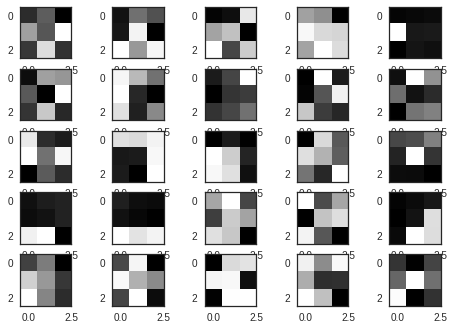

In [52]:
# make a figure for the first 25 filters
warnings.filterwarnings('ignore')
index = 0
for i in range(5):
    for j in range(5):
        w = weights[0][:,:,0,index]
        w = w.reshape(3, 3)
        index+=1
        plt.subplot(5, 5, index)
        plt.imshow(w, cmap='gray')    

plt.show()

---

## Fine-tuning a Pre-trained Network

We decided to fine-tune the **Inception-v3** network, which has been developed by Google for the ImageNet Competition in 2012. We chose to work with this model because of its high classification performance and its easy availability in TensorFlow.

Because the required image data is different, we resized the arrays, effectively adding bits of whitespace to the images.
In the initial phase, the base model is loaded, and a fully connected layer (with 1024 neurons) and a dense layer (with 19 output classes) are added on top. All base layers are frozen for initial training. After the top layers have been trained for 10 epochs, 207 of the base layers are then unfrozen for further training for 50 epochs.

In contrast to the above network trained from scratch, we used SGD with momentum of 0.9 as the optimization method.

#### Parameters

In [53]:
final_activation_function = 'softmax'
input_activation_function = 'relu'
input_kernel_size = (5, 5)
input_shape = (154, 154, 3)
pool_size = (3, 3)
hidden_activation_function = 'relu'
hidden_kernel_size = (3, 3)
loss_method = 'binary_crossentropy'
optimizer = SGD(lr=0.1, momentum=0.9)
eval_metric = 'accuracy'

#### Load Existing Model

In [54]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# Global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Logistic layer 
predictions = Dense(classes, activation=final_activation_function)(x)

# Model to train
model_tune = Model(inputs=base_model.input, outputs=predictions)

#### Model Summary

In [55]:
model_tune.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_99 (Conv2D)               (None, None, None, 32 864                                          
____________________________________________________________________________________________________
batch_normalization_95 (BatchNor (None, None, None, 32 96                                           
____________________________________________________________________________________________________
activation_95 (Activation)       (None, None, None, 32 0                                            
___________________________________________________________________________________________

#### Train the Top Layers
First, we train only the top layers (which were randomly initialized) for 10 epochs on our new dataset. All convolutional InceptionV3 layers are frozen for now.

In [56]:
for layer in model_tune.layers:
    layer.trainable = False
    
# compile the model (should be done *after* setting layers to non-trainable)
model_tune.compile(optimizer='rmsprop', loss='binary_crossentropy',  metrics=[eval_metric])

model_tune.layers

In [57]:
epochs = 10
tune_history = model_tune.fit(train_X, train_Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (test_X, test_Y))

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 73s - loss: 0.3798 - acc: 0.8954 - val_loss: 0.3906 - val_acc: 0.8949

#### Evaluate Predictions

In [58]:
pred_val_Y = np.round(model_tune.predict(val_X))

In [59]:
# show test accuracies for each class
acc_baseline = np.mean(pd.DataFrame(pred_val_Y, columns=genres.columns) == pd.DataFrame(val_Y, columns=genres.columns))
acc_baseline

Adventure          0.9257
Fantasy            0.9546
Animation          0.9436
Drama              0.5749
Horror             0.8941
Action             0.8480
Comedy             0.6964
History            0.9748
Western            0.9720
Thriller           0.8580
Crime              0.9150
Documentary        0.9077
Science Fiction    0.9406
Mystery            0.9517
Music              0.9561
Romance            0.8573
Family             0.9318
War                0.9759
Foreign            0.9268
dtype: float64

In [60]:
# overall accuracy
print("Overall accuracy CNN(fine-tuned top only)", round(acc_baseline.sum() / 19 * 100, 2), "%\n")

Overall baseline accuracy 89.5 %



In [61]:
# F1 score
print("Precision CNN(fine-tuned top only)", round(metrics.precision_score(val_Y, pred_val_Y, average='weighted'), 3))
print("Recall CNN(fine-tuned top only)", round(metrics.recall_score(val_Y, pred_val_Y, average='weighted'), 3))
print("F1 score CNN(fine-tuned top only)", round(metrics.f1_score(val_Y, pred_val_Y, average='weighted'), 3))

Precision baseline 0.004
Recall baseline 0.0
F1 score baseline 0.0


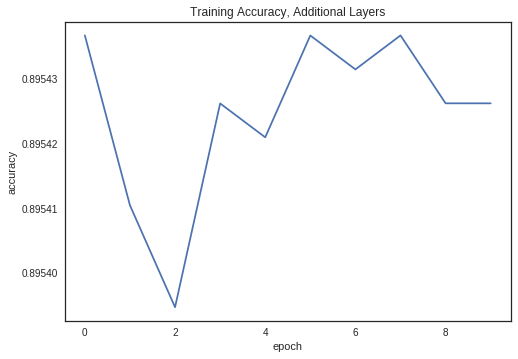

In [62]:
plt.plot(tune_history.history['acc'])
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Training Accuracy, Additional Layers");

As seen from above, the validation accuracy is similar to the existing trained network at around 89.5%. We now have well-trained top layers and can start fine-tuning the convolutional layers from the inception V3 model.

#### Print Layer Names and Indices
We first print out all the layer names and indices in order to see how many layers to unfreeze.

In [63]:
for i, layer in enumerate(model_tune.layers):
   print(i, layer.name)

0 input_2
1 conv2d_99
2 batch_normalization_95
3 activation_95
4 conv2d_100
5 batch_normalization_96
6 activation_96
7 conv2d_101
8 batch_normalization_97
9 activation_97
10 max_pooling2d_7
11 conv2d_102
12 batch_normalization_98
13 activation_98
14 conv2d_103
15 batch_normalization_99
16 activation_99
17 max_pooling2d_8
18 conv2d_107
19 batch_normalization_103
20 activation_103
21 conv2d_105
22 conv2d_108
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_104
29 conv2d_106
30 conv2d_109
31 conv2d_110
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_114
42 batch_normalization_110
43 activation_110
44 conv2d_112
45 conv2d_115
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_111
52 conv2d_113
5

In [64]:
for layer in model_tune.layers[:106]:
   layer.trainable = False
for layer in model_tune.layers[106:]:
   layer.trainable = True

We decide to keep the bottom 106 layers frozen, and unfreeze the remaining 207 layers on top. We recompile the model, using SGD with a very low learning rate. Further training is done for 50 epochs.

In [65]:
model_tune.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy',  metrics=[eval_metric])

In [58]:
# Fine tune the new model, using the "fine" parameters of SGD previously defined.
epochs = 50
tune_history = model_tune.fit(train_X, train_Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (test_X, test_Y))

Train on 10000 samples, validate on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 95s - loss: 0.3666 - acc: 0.8955 - val_loss: 0.3648 - val_acc: 0.8957

### Evaluating Network Performance

In [60]:
pred_val_Y = np.round(model_tune.predict(val_X))

In [61]:
# show test accuracies for each class
acc_baseline = np.mean(pd.DataFrame(pred_val_Y, columns=genres.columns) == pd.DataFrame(val_Y, columns=genres.columns))
acc_baseline

Adventure          0.9257
Fantasy            0.9546
Animation          0.9436
Drama              0.5738
Horror             0.8941
Action             0.8480
Comedy             0.6957
History            0.9754
Western            0.9720
Thriller           0.8580
Crime              0.9155
Documentary        0.9095
Science Fiction    0.9406
Mystery            0.9517
Music              0.9561
Romance            0.8573
Family             0.9318
War                0.9759
Foreign            0.9276
dtype: float64

In [62]:
# overall accuracy
print("Overall baseline CNN(fine-tuned)", round(acc_baseline.sum() / 19 * 100, 2), "%\n")

Overall baseline accuracy 89.51 %



In [69]:
# F1 score
print("Precision CNN(fine-tuned)", round(metrics.precision_score(val_Y, pred_val_Y, average='weighted'), 3))
print("Recall CNN(fine-tuned)", round(metrics.recall_score(val_Y, pred_val_Y, average='weighted'), 3))
print("F1 score CNN(fine-tuned)", round(metrics.f1_score(val_Y, pred_val_Y, average='weighted'), 3))

Precision baseline 0.14
Recall baseline 0.004
F1 score baseline 0.007


The test accuracy did not increase by much, but the precision, recall and F1 scores appear to have increased by a bit. However, it still appears that we are predicting a lot of '0' genre flags. 

The plot below visualises the training process. It appears that more epochs did not improve the performance which is surprising. The largest gains are in the first few epochs.

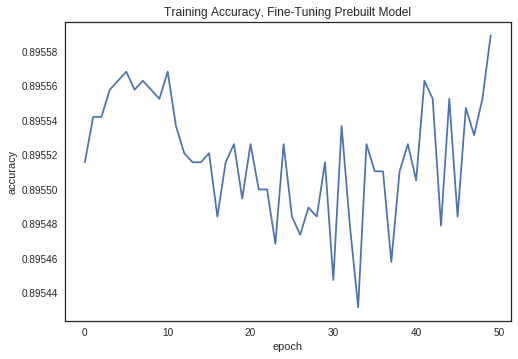

In [63]:
plt.plot(tune_history.history['acc'])
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Training Accuracy, Fine-Tuning Prebuilt Model");

### Features Learnt

Again, we visualize the filters in this model. The weights are the number of pixels times the number of filters, ie. the hidden units.

In [111]:
# Look at the weights of a layer
layer = model_tune.layers[52]
weights = layer.get_weights()
print("Shape of W")
print(weights[0].shape)

Shape of W
(5, 5, 48, 64)


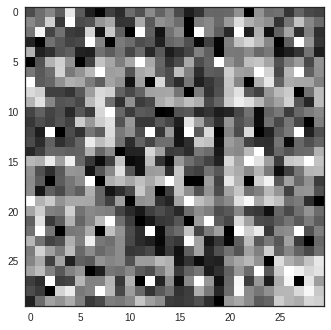

In [110]:
# First 36 filters
filterTiles = np.array([])
index = 0
for i in range(6):
    filterRow = []
    for j in range(6):
        w = weights[0][:,:, 0, index]
        w = w.reshape(5, 5)
        w = w-np.min(w)
        w = w / np.max(w)
        filterRow.extend(w)
        index+=1
    filterRow = np.array(filterRow)
    if not filterTiles.shape[0] == 0:
        filterTiles = np.hstack([filterTiles, filterRow])
    else:
        filterTiles = filterRow

plt.imshow(filterTiles, cmap='gray')    
plt.show()

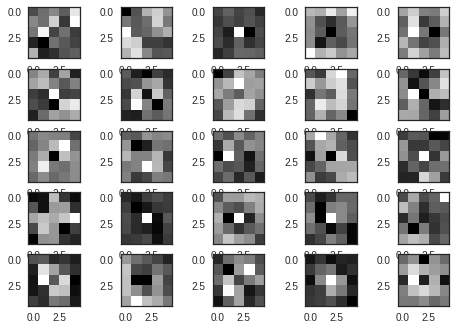

In [108]:
# make a figure for the first 25 filters
index = 0
for i in range(5):
    for j in range(5):
        w = weights[0][:,:,0,index]
        w = w.reshape(5, 5)
        index+=1
        plt.subplot(5, 5, index)
        plt.imshow(w, cmap='gray')    

plt.show()

---

## Discussion

Our networks had several weaknesses which we plan to address as follows:
- Further tuning of the network's architecture and parameters to improve performance, such as increasing the number of convolutional filters and number of neurons in the dense layer, decreasing the learning rate and batch size, etc.
- Address the class imbalance issue with class weights
- Increase the number of training and testing samples
- Generate Tensorflow log files for monitoring and visualization on Tensorboard (eg. loss curve)
- Add regularization and early stopping
- KIV insert BatchNorm layers

---

## Next Steps

Moving forward, we will work on improving our models as discussed above, and perhaps combine the predictions of our deep networks with earlier classifiers (eg. random forest) trained on movie metadata. We will present our final results in a screencast and report.